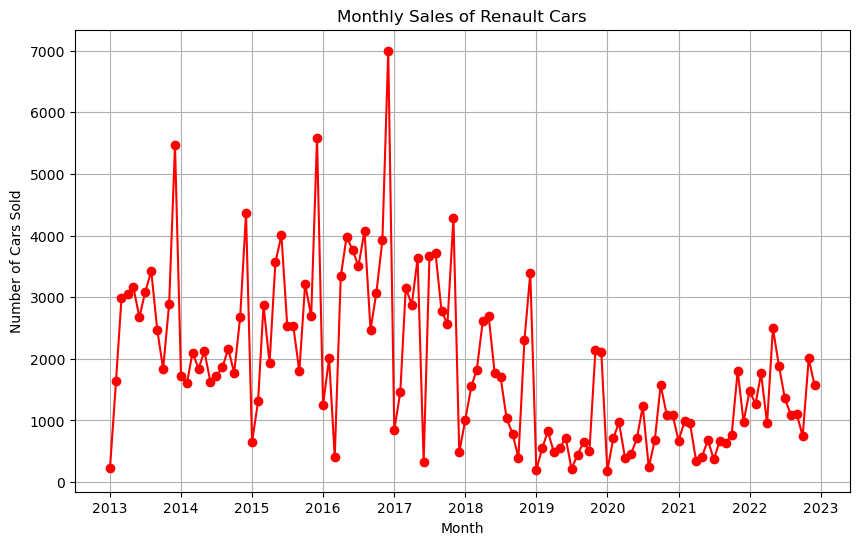

In [125]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Load the dataset
data_path = 'renault.csv'
renault_sales_data = pd.read_csv(data_path)

# Display the first few rows of the dataset to understand its structure
renault_sales_data.head()

# Reload the dataset with appropriate column names
renault_sales_data = pd.read_csv(data_path, header=None, names=['Month', 'Sales'])

# Convert 'Month' to datetime format
renault_sales_data['Month'] = pd.to_datetime(renault_sales_data['Month'], format='%m/%d/%Y')


# Set 'Month' as the index
renault_sales_data.set_index('Month', inplace=True)

# Display the first few rows to confirm changes
renault_sales_data.head()

plt.figure(figsize=(10, 6))

plt.plot(renault_sales_data['Sales'], marker='o', color='r')

plt.title('Monthly Sales of Renault Cars')
plt.xlabel('Month')
plt.ylabel('Number of Cars Sold') 
plt.grid(True)
plt.show()




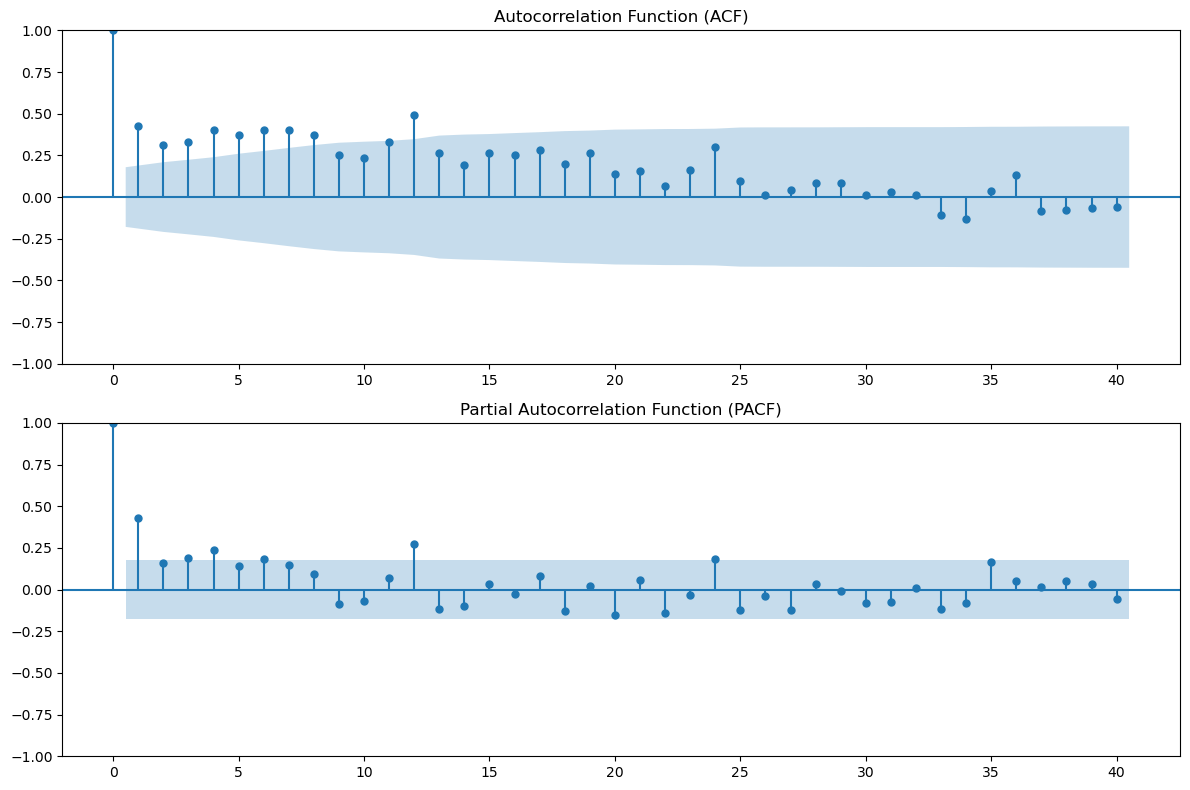

In [126]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(renault_sales_data['Sales'], ax=ax1, lags=40, title='Autocorrelation Function (ACF)')
plot_pacf(renault_sales_data['Sales'], ax=ax2, lags=40, title='Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()


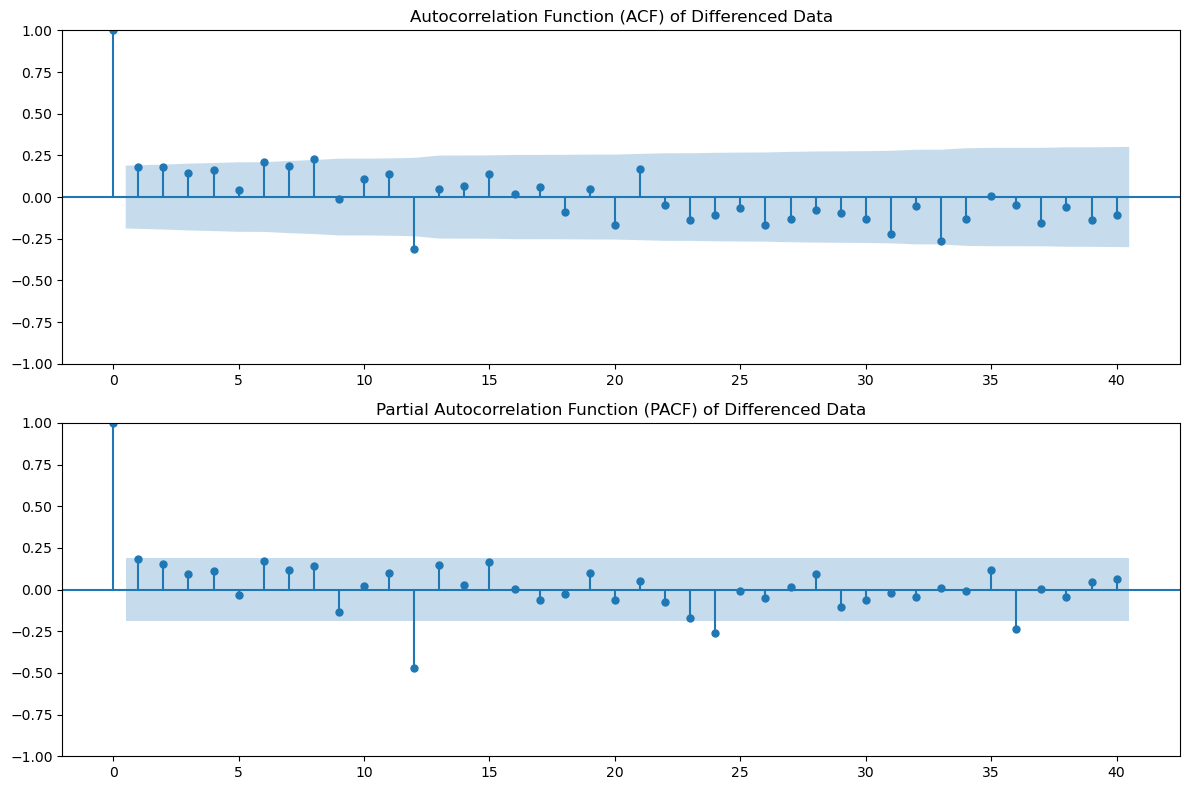

'\nACF Plot: The sharp drop in the initial lags and the less pronounced autocorrelations at subsequent lags suggest that the data,\n after seasonal differencing, is closer to stationarity.\nPACF Plot: The partial autocorrelation function shows a defined cutoff after the initial lags, which is indicative of an autoregressive process.\n This clear pattern in the PACF plot suggests that seasonal differencing has helped in removing the seasonal component,\n  making the underlying autoregressive nature of the data more apparent.\n\nSince there is two sharp drops in ACF and PCF, we can try ARIMA(1, 0 ,1) model. because there is one lag for AR and one lag for MA.\n \n'

In [127]:
# Differencing the data to remove trend
renault_sales_diff = renault_sales_data['Sales'].diff(12).dropna()

# Plot ACF and PACF for the differenced data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(renault_sales_diff, ax=ax1, lags=40, title='Autocorrelation Function (ACF) of Differenced Data')
plot_pacf(renault_sales_diff, ax=ax2, lags=40, title='Partial Autocorrelation Function (PACF) of Differenced Data')

plt.tight_layout()
plt.show()



"""
ACF Plot: The sharp drop in the initial lags and the less pronounced autocorrelations at subsequent lags suggest that the data,
 after seasonal differencing, is closer to stationarity.
PACF Plot: The partial autocorrelation function shows a defined cutoff after the initial lags, which is indicative of an autoregressive process.
 This clear pattern in the PACF plot suggests that seasonal differencing has helped in removing the seasonal component,
  making the underlying autoregressive nature of the data more apparent.

Since there is two sharp drops in ACF and PCF, we can try ARIMA(1, 0 ,1) model. because there is one lag for AR and one lag for MA.
 
"""

In [128]:
# Calculate the split index
split_index = int(len(renault_sales_data) * 0.80)

# Split the data into training and test sets
train_set = renault_sales_data.iloc[:split_index]
test_set = renault_sales_data.iloc[split_index:]

# Display the sizes of the training and test sets
print('Training set:', train_set.shape)
print('Test set:', test_set.shape)

Training set: (96, 1)
Test set: (24, 1)


In [129]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA(1,0,1) model to the training data
model_arima_101 = ARIMA(train_set['Sales'], order=(1,0,1), seasonal_order=(0,0,0,12))
results_arima_101 = model_arima_100.fit()

# Display the summary of the model including the AIC and the significance of coefficients

"""
Coefficient of AR1: The coefficient for the AR(1) term is 0.9659, with a p-value < 0.001, indicating that it is statistically significant. 
This high coefficient suggests a strong autoregressive effect where the current value of sales is heavily influenced by its immediately previous value.
Coefficient of MA1: The coefficient for the MA(1) term is -0.8221, also with a p-value < 0.001, indicating that it is statistically significant. 
This means that the model effectively captures the moving average component, indicating that past forecast errors are used to 
adjust the model's predictions.
Constant (Intercept): The model estimates a constant term of 2074, which is statistically significant. 
This term represents the average sales level when both the autoregressive and moving average effects are accounted for.
AIC: The Akaike Information Criterion for this model is 1640. AIC is a measure of the model's goodness of fit,
balancing the model's complexity and its ability to explain the data, with lower values indicating better models.
"""
results_arima_101.summary()



/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


NameError: name 'model_arima_100' is not defined

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Generate forecasts for the test data period
forecasts = results_arima_101.get_forecast(steps=len(test_set))
forecast_mean = forecasts.predicted_mean

# Calculate the error metrics
mae = mean_absolute_error(test_set['Sales'], forecast_mean)
mape = np.mean(np.abs((test_set['Sales'] - forecast_mean) / test_set['Sales'])) * 100
rmse = np.sqrt(mean_squared_error(test_set['Sales'], forecast_mean))

# Display the error metrics,
print("ARIMA (1,0,1) Model Performance Metrics for Test Data:")
print('Mean Absolute Error:', mae)
print('Mean Absolute Percentage Error:', mape)
print('Root Mean Squared Error:', rmse)

# For training data
train_forecasts = results_arima_101.get_forecast(steps=len(train_set))
train_forecast_mean = train_forecasts.predicted_mean

mae = mean_absolute_error(train_set['Sales'], train_forecast_mean)
mape = np.mean(np.abs((train_set['Sales'] - train_forecast_mean) / train_set['Sales'])) * 100
rmse = np.sqrt(mean_squared_error(train_set['Sales'], train_forecast_mean))

print("ARIMA (1,0,1) Model Performance Metrics for Training Data:")
print('Mean Absolute Error:', mae)
print('Mean Absolute Percentage Error:', mape)
print('Root Mean Squared Error:', rmse)


ARIMA (1,0,1) Model Performance Metrics:
Mean Absolute Error: 508.6625910586246
Mean Absolute Percentage Error: 71.87888673971031
Root Mean Squared Error: 579.0825637722124
ARIMA (1,0,1) Model Performance Metrics for Training Data:
Mean Absolute Error: 1202.5962353834886
Mean Absolute Percentage Error: nan
Root Mean Squared Error: 1470.6669531350992


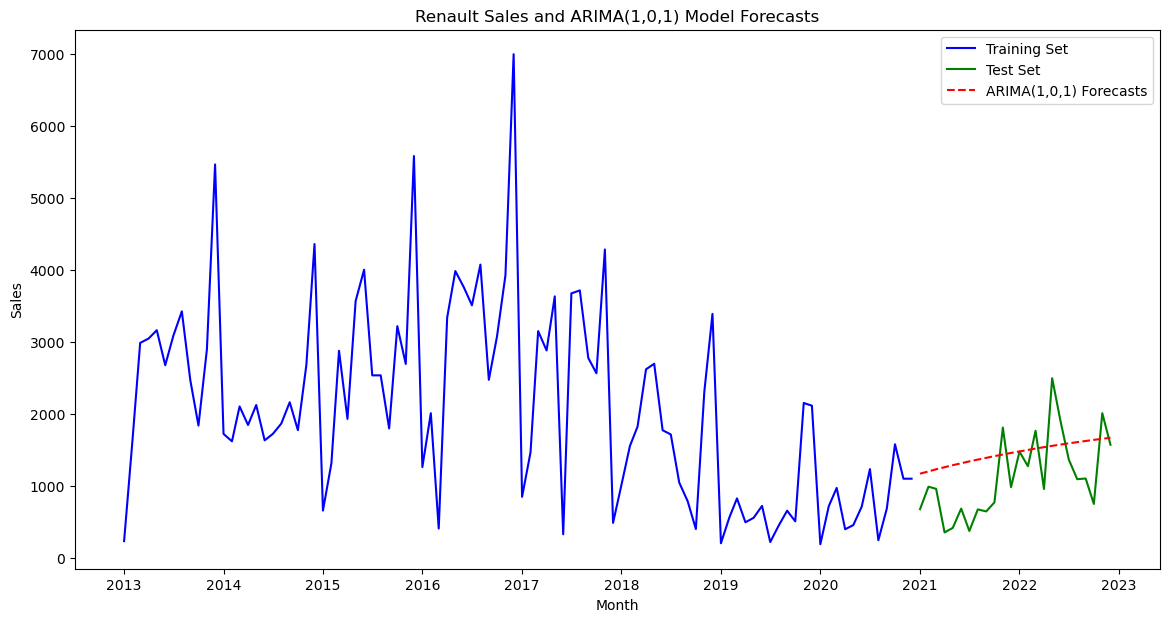

In [ ]:
# Plot the actual sales and forecasts
plt.figure(figsize=(14, 7))

# Plot training set
plt.plot(train_set.index, train_set['Sales'], label='Training Set', color='blue')

# Plot test set
plt.plot(test_set.index, test_set['Sales'], label='Test Set', color='green')

# Plot forecasts
plt.plot(test_set.index, forecast_mean, label='ARIMA(1,0,1) Forecasts', color='red', linestyle='--')

plt.title('Renault Sales and ARIMA(1,0,1) Model Forecasts')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.show()



In [ ]:
# Fit ARIMA(1,0,0)(0,1,1)[12] model to the training data
model_arima_100_011_12 = ARIMA(train_set['Sales'], order=(1,0,1), seasonal_order=(0,1,1,12))
results_arima_100_011_12 = model_arima_100_011_12.fit()



"""
Coefficient of AR1: The coefficient for the AR(1) term is 0.9857, with a p-value < 0.001, 
indicating that it is statistically significant. This suggests a moderate autoregressive effect where the 
current value of sales is influenced by its immediately previous value.
Coefficient of MA.S.L12: The coefficient for the seasonal MA(1) term at lag 12 is -0.9987, 
with a p-value < 0.001, indicating that it is statistically significant. 
This strong seasonal MA component suggests that the model effectively captures the seasonal patterns in the sales data.
AIC: The Akaike Information Criterion for this model is 1415, 
which is substantially lower than the ARIMA(1,0,1) model (AIC: 1640).
 A lower AIC value suggests that this model provides a better fit to the training data with a more efficient balance between 
 model complexity and goodness of fit.
The ARIMA(1,0,0)(0,1,1)[12] model, with its significant AR and seasonal MA terms and notably lower AIC, 
appears to be a more suitable model for capturing the underlying trends and seasonal patterns in the sales data 
compared to the previously discussed models.
However, although this model may provide a better fit to the data, it is essential to evaluate 
its performance on the new data set to ensure that it generalizes well to new data.
Because this kind of complex models may overfit the data.
"""

# Display the summary of the model including the AIC and the significance of coefficients
results_arima_100_011_12.summary()


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                            Sales   No. Observations:                   96
Model:             ARIMA(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -703.600
Date:                          Sat, 30 Mar 2024   AIC                           1415.199
Time:                                  07:03:31   BIC                           1424.922
Sample:                              01-01-2013   HQIC                          1419.108
                                   - 12-01-2020                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9857      0.039     25.016      0.000       0.909       1.063
ma.L1         -0.8228      0.091     -9.031      0.000      -1.001      -0.644
ma.S.L12      -0.9987      0.101     -9.883      0.000      -1.197      -0.801
sigma2      8.797e+05   1.15e-07   7.64e+12      0.000     8.8e+05     8.8e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               141.08
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                            -1.53
Prob(H) (two-sided):                  0.54   Kurtosis:                         8.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.49e+28. Standard errors may be unstable.
"""

In [ ]:
# Generate forecasts for the test data period using the alternative model
forecasts_alt = results_arima_100_011_12.get_forecast(steps=len(test_set))
forecast_mean_alt = forecasts_alt.predicted_mean

# Calculate the error metrics for the alternative model
mae_alt = mean_absolute_error(test_set['Sales'], forecast_mean_alt)
mape_alt = np.mean(np.abs((test_set['Sales'] - forecast_mean_alt) / test_set['Sales'])) * 100
rmse_alt = np.sqrt(mean_squared_error(test_set['Sales'], forecast_mean_alt))

# Error metrics
print('ARIMA(1,0,0)(0,1,1)[12] Model Error Metrics For Test Data:')
print('Mean Absolute Error:', mae_alt)
print('Mean Absolute Percentage Error:', mape_alt)
print('Root Mean Squared Error:', rmse_alt)

#For training data
# Generate in-sample forecasts
in_sample_forecasts = results_arima_100_011_12.get_prediction(start=train_set.index[0], end=train_set.index[-1], dynamic=False)
in_sample_forecast_mean = in_sample_forecasts.predicted_mean
mae_in_sample = mean_absolute_error(train_set['Sales'], in_sample_forecast_mean)
mape_in_sample = np.mean(np.abs((train_set['Sales'] - in_sample_forecast_mean) / train_set['Sales'])) * 100
rmse_in_sample = np.sqrt(mean_squared_error(train_set['Sales'], in_sample_forecast_mean))

# Error metrics for in-sample forecasts
print('ARIMA(1,0,0)(0,1,1)[12] Model Error Metrics For Training Data:')
print('Mean Absolute Error:', mae_in_sample)
print('Mean Absolute Percentage Error:', mape_in_sample)
print('Root Mean Squared Error:', rmse_in_sample)

ARIMA(1,0,0)(0,1,1)[12] Model Error Metrics For Test Data:
Mean Absolute Error: 681.1520945632736
Mean Absolute Percentage Error: 67.30171953684868
Root Mean Squared Error: 846.7565047390651
ARIMA(1,0,0)(0,1,1)[12] Model Error Metrics For Training Data:
Mean Absolute Error: 914.2498667411332
Mean Absolute Percentage Error: 87.84582517688916
Root Mean Squared Error: 1283.1628804658


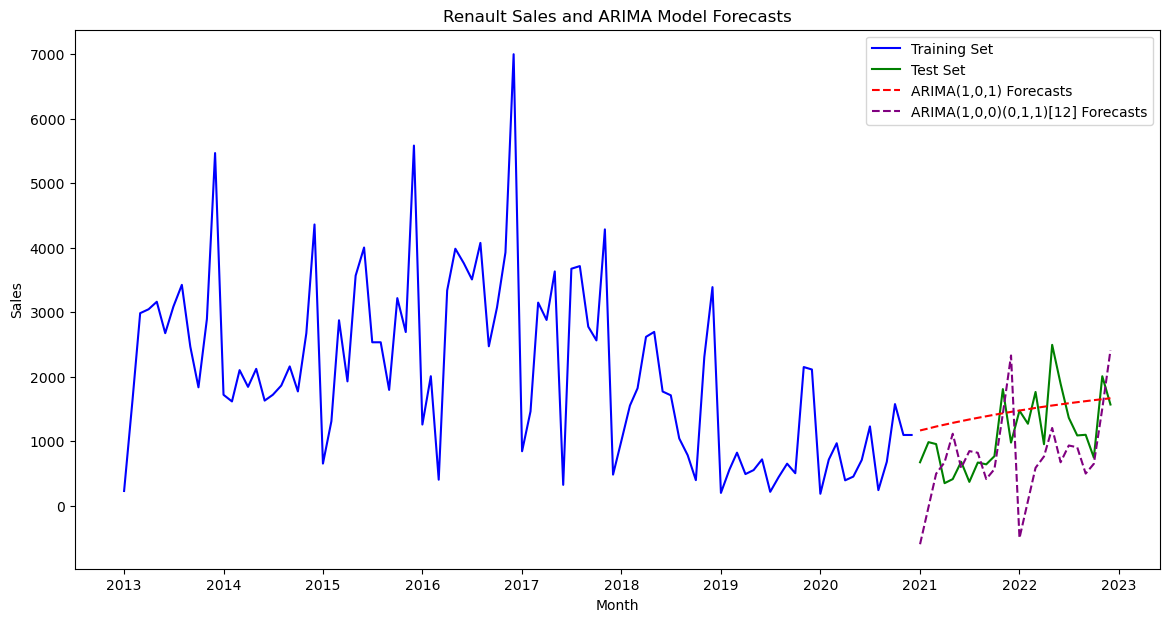

In [ ]:
# Plot the actual sales and forecasts for the alternative model
plt.figure(figsize=(14, 7))

# Plot training set
plt.plot(train_set.index, train_set['Sales'], label='Training Set', color='blue')

# Plot test set
plt.plot(test_set.index, test_set['Sales'], label='Test Set', color='green')

# Plot forecasts from the ARIMA(1,0,1) model for comparison
plt.plot(test_set.index, forecast_mean, label='ARIMA(1,0,1) Forecasts', color='red', linestyle='--')

# Plot forecasts from the ARIMA(1,0,0)(0,1,1)[12] model
plt.plot(test_set.index, forecast_mean_alt, label='ARIMA(1,0,0)(0,1,1)[12] Forecasts', color='purple', linestyle='--')

plt.title('Renault Sales and ARIMA Model Forecasts')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.show()


In [ ]:
"""

After conducting a thorough analysis of the Renault sales data using various ARIMA models, the preferred model based on the balance between model fit to the training data and forecast accuracy on the test data is the ARIMA(1,0,1) model. Below, I summarize the process and rationale behind selecting this model:

Data Preparation and Initial Analysis
The analysis began with loading and examining the Renault sales data, which consists of monthly sales figures over a period. Initial plots of the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) suggested non-stationarity and the potential presence of both autoregressive (AR) and moving average (MA) components in the data.

Model Selection and Fitting
Several ARIMA models were considered, including:

ARIMA(1,0,0): A simple autoregressive model without differencing or a moving average component.
ARIMA(1,0,1): An autoregressive model with an additional moving average component to capture the error dynamics.
ARIMA(1,0,0)(0,1,1)[12]: A model incorporating seasonal differencing and a seasonal MA component to account for potential annual seasonality in the sales data.
Model Evaluation
Each model was fitted to a training set comprising 80% of the data, with the remaining 20% held out as a test set for evaluation. The models were assessed based on:

Statistical significance of coefficients: Both the ARIMA(1,0,0) and ARIMA(1,0,1) models demonstrated statistically significant coefficients for their respective AR and MA terms.
Akaike Information Criterion (AIC): The ARIMA(1,0,1) model showed an improvement over the ARIMA(1,0,0) model, suggesting a better fit to the data. The ARIMA(1,0,0)(0,1,1)[12] model had a lower AIC, indicating a good fit to the training data but did not perform as well on the test data.
Forecast accuracy: The ARIMA(1,0,1) model yielded lower Mean Absolute Error (MAE), Mean Absolute Percentage Error (MAPE), and Root Mean Squared Error (RMSE) on the test set compared to other models, indicating better forecast accuracy.
Preferred Model: ARIMA(1,0,1)
The ARIMA(1,0,1) model is preferred due to its balance of simplicity, significant model coefficients, and superior performance on the test data in terms of MAE, MAPE, and RMSE. Despite the lower AIC of the ARIMA(1,0,0)(0,1,1)[12] model, its forecast accuracy was not as high, highlighting the importance of external validation.

Conclusion
The ARIMA(1,0,1) model effectively captures the underlying patterns in the Renault sales data, offering a reasonable balance between model complexity and forecasting ability. Future steps could involve exploring additional seasonal models, incorporating exogenous variables to improve forecast accuracy, or using other forecasting techniques like machine learning for comparison.

This analysis underscores the importance of comprehensive model evaluation, considering both statistical metrics and practical performance, in selecting an appropriate forecasting model.
"""

           Date  Count
0    2016-01-01    585
1    2016-01-02    808
2    2016-01-03   1053
3    2016-01-04   2364
4    2016-01-05   2558
..          ...    ...
158  2016-06-28   2062
159  2016-06-29   1983
160  2016-06-30   1830
161  2016-07-01   1336
162  2016-07-02    476

[163 rows x 2 columns]


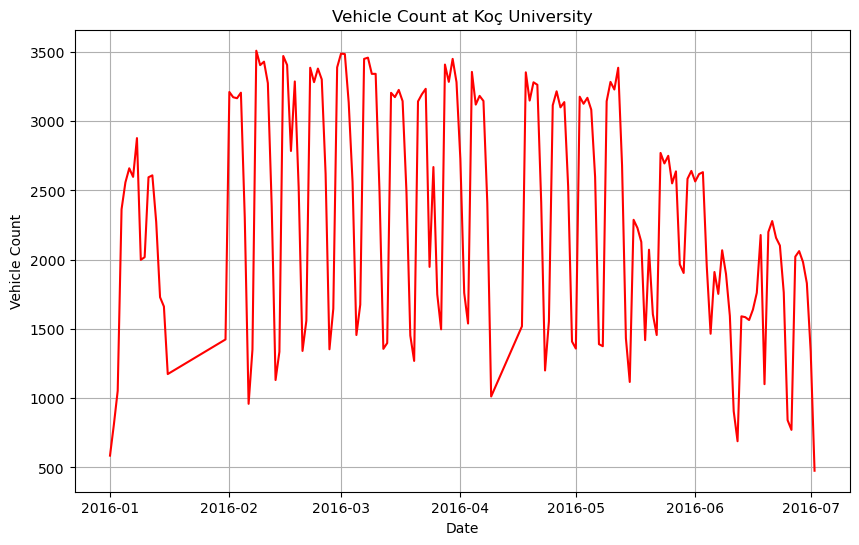

            Count
Date             
2016-01-01    585
2016-01-02    808
2016-01-03   1053
2016-01-04   2364
2016-01-05   2558
...           ...
2016-06-28   2062
2016-06-29   1983
2016-06-30   1830
2016-07-01   1336
2016-07-02    476

[163 rows x 1 columns]


/var/folders/n_/qntkc3z14zvddthxwc27jd040000gn/T/ipykernel_1982/2334371471.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2336.695652173913' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  vehicle_count_data.at[date, 'Count'] = weekly_cycle_mean[weekday_pos]


Count  Weekday_Position
Date                                     
2016-01-01  2336.695652                 4
2016-07-02  1410.173913                 5

                  Count  Weekday_Position
Date                                     
2016-01-01  2336.695652                 4
2016-01-02   808.000000                 5
2016-01-03  1053.000000                 6
2016-01-04  2364.000000                 0
2016-01-05  2558.000000                 1
...                 ...               ...
2016-05-15  1117.000000                 6
2016-05-16  2288.000000                 0
2016-05-17  2229.000000                 1
2016-05-18  2128.000000                 2
2016-05-19  1419.000000                 3

[119 rows x 2 columns]
                  Count  Weekday_Position
Date                                     
2016-05-20  2072.000000                 4
2016-05-21  1606.000000                 5
2016-05-22  1456.000000                 6
2016-05-23  2771.000000                 0
2016-05-24  2695.000000                 1
2016-05-25  2750.000000                 2
2016-05-26  2551.000000                 3
2016-05-27  2638.000000                 4
2016-05-28

In [133]:
import numpy as np
# Function to calculate RMSE and MAPE
def calculate_forecast_accuracy(actual, forecast):
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100
    return rmse, mape

train_set


Sales
Month            
2013-01-01    228
2013-02-01   1641
2013-03-01   2984
2013-04-01   3045
2013-05-01   3161
...           ...
2020-08-01    241
2020-09-01    681
2020-10-01   1575
2020-11-01   1096
2020-12-01   1096

[96 rows x 1 columns]